#LINEAR SVM + PCA (HOG FEATURES)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import load_iris

# === Load data ===
#base_dir = "/content/drive/MyDrive/train features"
#test_dir = f"{base_dir}/test features"

X_train = np.load(f"{base_dir}/hog_features.npy")
y_train = np.load(f"{base_dir}/labels_train.npy")
X_test = np.load(f"{test_dir}/hog_features_test.npy")
y_test = np.load(f"{test_dir}/labels_test.npy")


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=300)),  # Try 100–500 components
    ('clf', SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3))
])


param_dist = {
    'clf__alpha': [1e-4, 1e-3, 1e-2],
    'clf__penalty': ['l2', 'l1', 'elasticnet'],
    'clf__learning_rate': ['optimal', 'adaptive'],
}

search = RandomizedSearchCV(pipeline, param_dist, n_iter=10, cv=3, verbose=1, n_jobs=1,return_train_score=False)
search.fit(X_train, y_train)


# Use best model to predict on test set
y_pred = search.best_estimator_.predict(X_test)

# Print classification results
print("Test Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Predict on the test set
y_pred = search.best_estimator_.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
print(" Best Hyperparameters Found:")
print(search.best_params_)
#Test Set Evaluation:
#Accuracy: 0.5689
# Best Hyperparameters Found:
#{'clf__penalty': 'l1', 'clf__learning_rate': 'optimal', 'clf__alpha': 0.001}

#SVC-RBF,PCA(hog features)


In [ ]:
# Load data
X_train = np.load('hog_features.npy')
y_train = np.load('labels_train.npy')
X_test = np.load('hog_features_test.npy')
y_test = np.load('labels_test.npy')

# Step 1: Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: PCA
pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 3: Train SVM
svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(X_train_pca, y_train)

# Step 4: Evaluate
y_pred = svm.predict(X_test_pca)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.771793054571226

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.63      0.61       723
           1       0.75      0.74      0.75      1203
           2       0.85      0.81      0.83      2038
           3       0.83      0.97      0.89       269

    accuracy                           0.77      4233
   macro avg       0.75      0.79      0.77      4233
weighted avg       0.77      0.77      0.77      4233



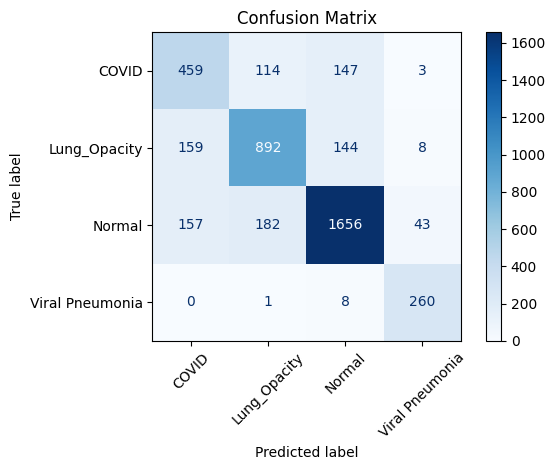

In [ ]:
#actual labels
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Cumulative explained variance by 200 components: 62.06%


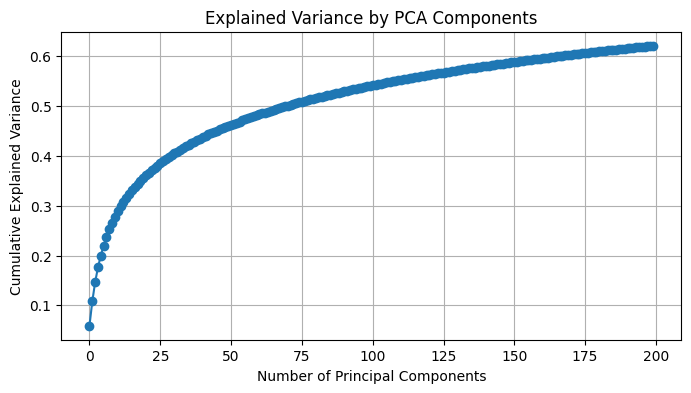

In [ ]:
# After PCA has been fitted
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative variance explained by the 200 components
cumulative_variance = np.cumsum(explained_variance_ratio)

# Print the final cumulative variance (i.e., total explained by the 200 components)
print(f"Cumulative explained variance by 200 components: {cumulative_variance[-1]*100:.2f}%")

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(explained_variance_ratio), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [ ]:
import joblib
# Save the model, scaler, and PCA
joblib.dump(svm, 'svm_rbf_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(pca, 'pca.joblib')

['pca.joblib']

#SVC-rbf -grid search, smaller dataset- hog features


In [ ]:
# Load features and labels
X = np.load('hog_features.npy')
y = np.load('labels_train.npy')
X_test = np.load('hog_features_test.npy')
y_test = np.load('labels_test.npy')


# Simple pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

params = {
    'svc__C': [0.1, 1],
    'svc__gamma': ['scale', 0.01]
}

# Use a smaller dataset for testing grid search
X_small, _, y_small, _ = train_test_split(X, y, train_size=5000, stratify=y)

# Perform grid search with reduced parameter space
grid = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_small, y_small)

# Print best params and results
print(grid.best_params_)
print(grid.best_score_)



Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'svc__C': 1, 'svc__gamma': 'scale'}
0.7159998972594437


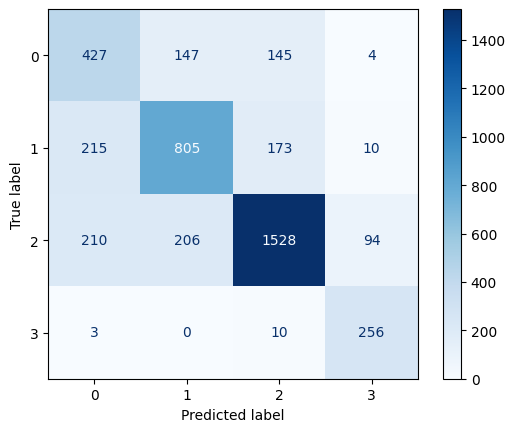

In [ ]:
# Use the best model from GridSearchCV
best_model = grid.best_estimator_

# Predict on the actual test set
y_pred = best_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # Use white-to-blue gradient

